# Policy gradient

In this tutorial lecture we will take a closer look at **Policy Gradient methods**.

Recall that if we want to maximize a performance measure $J(\theta)$ that depends on the policy parameter $\theta \in \Theta$, a standard approach is to improve the policy by following the gradient ascent:

$$ \theta_{t+1} = \theta_t + \alpha\widehat{\nabla J(\theta_t)} $$

where $\alpha$ is the learning rate. But how do we copmute $\widehat{\nabla J(\theta_t)}$?

It turns out that:

$$ \nabla J(\theta_t) \propto \mathbb{E}_\pi[G_t \nabla\log(\pi(a\vert s, \theta))] $$

hence every sample of that quantity yields an umbiased estimate for the gradient!

The update becomes:

$$ \theta_{t+1} = \theta_t + \alpha G_t \nabla\log(\pi(a\vert s, \theta)) $$

In this notebook, we will understand how the REINFORCE algorithm may be implemented to solve another instance of the class of the gridworld environments: _short corridor_.

Then we will exmaine the simplest example of **baseline**, which is as easy as it is a powerful method to accelerate the learning of the optimal policy. It serves also as a bridge from the simplest implementation of the Policy Gradient ideas, i.e. the Monte Carlo REINFORCE, to the more advanced Actor-Critic algorithms.

### Usual credits and imports


In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2018 Sergii Bondariev (sergeybondarev@gmail.com)                    #
# 2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm


### Short corridor with switched actions

The environment we will try to solve thorugh Policy Gradient methods is the _short corridor with switched actions_.

It is a gridworld environment with only 4 states and 2 actions:


1. The leftmost state is the _starting state_ (i.e. every episode always begins in this state). Two actions are available:
    - _left_: no movement
    - _right_: move to the right (i.e. in the second state)


2. The second state has the same actions but with opposite outcomes:
    - _left_: move to the right (i.e. in the third state)
    - _right_: move to the left (i.e. in the first state)


3. The third state is similar to the first, except that it is not a starting state. Again the actions are:
    - _left_: move to the left (i.e. in the second state)
    - _right_: move to the right (i.e. in the fouth state)


4. The fourth state is the _goal state_, in which the episode ends.

The reward is simply -1 for each transition (apart from the last one leading to the fourth state), therefore our aim
will be to minimize the number of transitions in order to reach the goal state.

In the code below you can see that the environment is implemented through a standard `step` function, with a specific
label for the actions. Here the function does not return the next state but only updates its value as an inner variable
of the class.
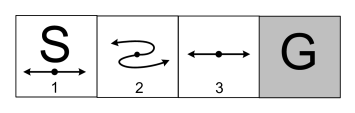

In [2]:
class ShortCorridor:
    """
    Short corridor environment, see Example 13.1
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.state = 0  # Initialize the environment to the starting state

    def step(self, go_right):
        """
        Args:
            go_right (bool): chosen action
        Returns:
            tuple of (reward, done)
        """
        if self.state == 0 or self.state == 2:  # first or third state
            if go_right:
                self.state += 1
            else:
                self.state = max(0, self.state - 1)  # taking care of the wall in the first state
        else:  # second state with opposite outcomes
            if go_right:
                self.state -= 1
            else:
                self.state += 1

        if self.state == 3:
            # terminal state
            return 0, True
        else:
            return -1, False


As you already know if we assume the dynamics are known, we can compute the true value-function by means of dynamic
programming, thanks to the Bellman equation. The following function returns the true value-function of the first state
which has been computed manually with this method.


In [3]:
def true_value(p):
    """ True value of the first state
    Args:
        p (float): probability of the action 'right'.
    Returns:
        True value of the first state.
        The expression is obtained by manually solving the easy linear system
        of Bellman equations using known dynamics.
    """
    return (2 * p - 4) / (p * (1 - p))


The code below defines the "REINFORCE" agent. It is a _Monte Carlo_ algorithm, therefore we need to store the trajectory
to perform the updates backward.

The function approximation in this example is willingly taken as too coarse: in particular we will be able to
distinguish the actions, left and right, but not the states. Our approximation will assign each state the same value for
the action-value function. This is done so that the optimal policy is a stochastic one (with almost equal probability of
selecting right or left), that is indeed learn accurately by the Policy Gradient method.


In [4]:
class ReinforceAgent:
    """
    ReinforceAgent that follows 'REINFORCE Monte-Carlo Policy-Gradient Control (episodic)' algorithm
    """
    def __init__(self, alpha, gamma):
        # set values such that initial conditions correspond to left-epsilon greedy - Worst policy
        self.theta = np.array([-1.47, 1.47])
        self.alpha = alpha
        self.gamma = gamma
        # first column - left, second - right
        self.x = np.array([[0, 1],
                           [1, 0]])
        self.rewards = []
        self.actions = []

    def get_pi(self):
        """
        Softmax distribution over actions - always kept stochastic by epsilon lower bound on probability
        """
        h = np.dot(self.theta, self.x)
        t = np.exp(h - np.max(h))
        pmf = t / np.sum(t)
        # never become deterministic,
        # guarantees episode finish
        imin = np.argmin(pmf)
        epsilon = 0.05

        if pmf[imin] < epsilon:
            pmf[:] = 1 - epsilon
            pmf[imin] = epsilon

        return pmf

    def get_p_right(self):
        return self.get_pi()[1]

    def choose_action(self, reward):
        """
        Choose action according to the softmax distribution
        """
        if reward is not None:
            self.rewards.append(reward)

        pmf = self.get_pi()
        go_right = np.random.uniform() <= pmf[1]
        self.actions.append(go_right)

        return go_right

    def episode_end(self, last_reward):
        self.rewards.append(last_reward)

        G = np.zeros(len(self.rewards))
        G[-1] = self.rewards[-1]  # last reward has not been appended

        # Monte Carlo backward updates
        for i in range(2, len(G) + 1):
            G[-i] = self.gamma * G[-i + 1] + self.rewards[-i]

        gamma_pow = 1

        for i in range(len(G)):
            j = 1 if self.actions[i] else 0
            pmf = self.get_pi()
            # the following term is the gradient of the log of the policy
            grad_ln_pi = self.x[:, j] - np.dot(self.x, pmf)
            update = self.alpha * gamma_pow * G[i] * grad_ln_pi

            self.theta += update
            gamma_pow *= self.gamma

        self.rewards = []
        self.actions = []


With the function below we implement a method to greatly reduce the variance of the gradient, so that the learning
process is faster. This is done by introducing a _baseline_, which is given by the Monte Carlo estimate of the
value-function. You can try to prove what is the best possible baseline by minimizing the variance of the gradient.

In particular the class below extends the `ReinforceAgent` above and overwrites the method `episode_end` in such a way
that it keeps also an estimate of the value-function.


In [5]:
class ReinforceBaselineAgent(ReinforceAgent):
    def __init__(self, alpha, gamma, alpha_w):
        super(ReinforceBaselineAgent, self).__init__(alpha, gamma)
        self.alpha_w = alpha_w
        self.w = 0

    def episode_end(self, last_reward):
        self.rewards.append(last_reward)

        # learn theta
        G = np.zeros(len(self.rewards))
        G[-1] = self.rewards[-1]

        for i in range(2, len(G) + 1):
            G[-i] = self.gamma * G[-i + 1] + self.rewards[-i]

        gamma_pow = 1

        for i in range(len(G)):
            # estimate of the value-function through a Monte Carlo algorithm (always under function approximation)
            self.w += self.alpha_w * gamma_pow * (G[i] - self.w)

            j = 1 if self.actions[i] else 0
            pmf = self.get_pi()
            grad_ln_pi = self.x[:, j] - np.dot(self.x, pmf)
            # subtracting the baseline
            update = self.alpha * gamma_pow * (G[i] - self.w) * grad_ln_pi

            self.theta += update
            gamma_pow *= self.gamma

        self.rewards = []
        self.actions = []


The function `trial` runs the REINFORCE algorithm for the specified number of episode (each of which has a stochastic length) with a given agent.


In [6]:
def trial(num_episodes, agent_generator):
    env = ShortCorridor()
    agent = agent_generator()

    rewards = np.zeros(num_episodes)
    for episode_idx in range(num_episodes):
        rewards_sum = 0
        reward = None
        env.reset()

        while True:
            go_right = agent.choose_action(reward)
            reward, episode_end = env.step(go_right)
            rewards_sum += reward

            if episode_end:
                agent.episode_end(reward)
                break

        rewards[episode_idx] = rewards_sum

    return rewards


Let's plot the true value-function w.r.t. the probability of taking action "right".

It is plain to see that the optimal policy is indeed stochastic and has high entropy.


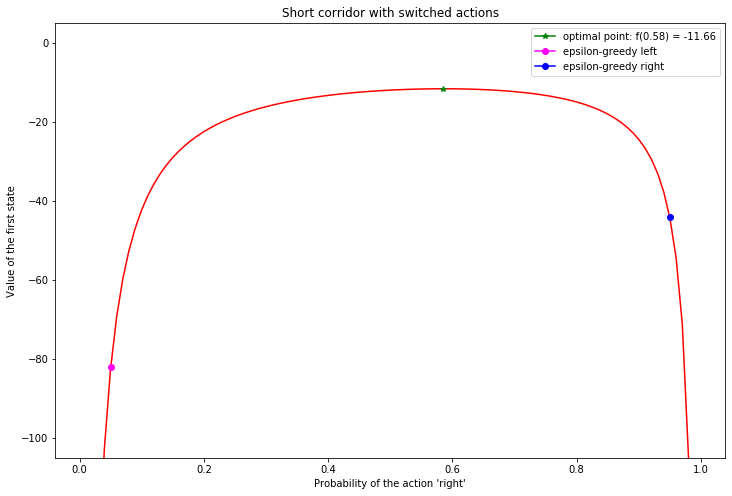

In [12]:
epsilon = 0.05
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot a graph
p = np.linspace(0.01, 0.99, 100)
y = true_value(p)
ax.plot(p, y, color='red')

# Find a maximum point, can also be done analytically by taking a derivative
imax = np.argmax(y)
pmax = p[imax]
ymax = y[imax]
ax.plot(pmax, ymax, color='green', marker="*", label="optimal point: f({0:.2f}) = {1:.2f}".format(pmax, ymax))

# Plot points of two epsilon-greedy policies
ax.plot(epsilon, true_value(epsilon), color='magenta', marker="o", label="epsilon-greedy left")
ax.plot(1 - epsilon, true_value(1 - epsilon), color='blue', marker="o", label="epsilon-greedy right")

ax.set_ylabel("Value of the first state")
ax.set_xlabel("Probability of the action 'right'")
ax.set_title("Short corridor with switched actions")
ax.set_ylim(ymin=-105.0, ymax=5)
ax.legend()

plt.show()
plt.close()


Next, we plot the rewards obtained by the REINFORCE agent averaged over 100 trials of 500 episodes each.

Notice two things:

- The policy gradient can indeed learn the (almost) optimal policy: when the correct learning rate is chosen, the agent
achieves a reward similar to the optimal value-function, hence it is behaving optimally.

- The polciy gradient method can be very sensitive with respect to the learning rate. This may be a major issue when
actually deploying the algorithm to solve a non-trivial environment (often in practice the theoretical guarantees are
not enough).


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


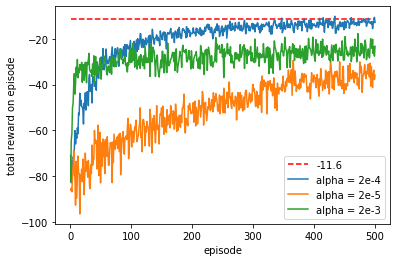

In [15]:
num_trials = 100
num_episodes = 500
gamma = 1
agent_generators = [lambda : ReinforceAgent(alpha=2e-4, gamma=gamma),
                    lambda : ReinforceAgent(alpha=2e-5, gamma=gamma),
                    lambda : ReinforceAgent(alpha=2e-3, gamma=gamma)]
labels = ['alpha = 2e-4',
          'alpha = 2e-5',
          'alpha = 2e-3']

rewards = np.zeros((len(agent_generators), num_trials, num_episodes))

for agent_index, agent_generator in enumerate(agent_generators):
    for i in tqdm(range(num_trials)):
        reward = trial(num_episodes, agent_generator)
        rewards[agent_index, i, :] = reward

plt.plot(np.arange(num_episodes) + 1, -11.6 * np.ones(num_episodes), ls='dashed', color='red', label='-11.6')
for i, label in enumerate(labels):
    plt.plot(np.arange(num_episodes) + 1, rewards[i].mean(axis=0), label=label)
plt.ylabel('total reward on episode')
plt.xlabel('episode')
plt.legend(loc='lower right')

plt.show()
plt.close()


In the last plot we can see the performances of the same algorithm, when enriched with the baseline!

The baseline $b(s)$ (as long as it does not depend on the action) does not harm our unbiased estimate of the gradient, since:

$$ \sum_a b(s) \nabla \pi(a\vert s, \theta) = b(s) \sum_a \nabla \pi(a\vert s, \theta) = b(s) \nabla \sum_a \pi(a\vert s, \theta) = b(s) \nabla 1 = 0 $$

so that our new update will be:

$$ \theta_{t+1} = \theta_t + \alpha (G_t-b(s)) \nabla\log(\pi(a\vert s, \theta)) $$

Notice the faster learning speed it achieves: this is also due to the possibility of considering a higher learning rate,
which in the example is 10 times bigger! The effect of such a learning rate in the classical algorithm would be
disastrous, given the high variance of the gradient. While with the baseline the variance si reduced, and so we can
afford a higher learning rate.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.40it/s]


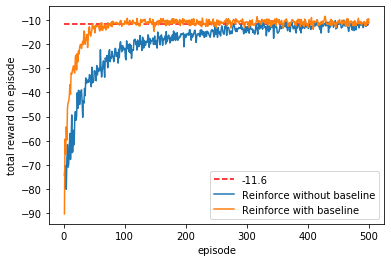

In [16]:
num_trials = 100
num_episodes = 500
alpha = 2e-4
gamma = 1
agent_generators = [lambda : ReinforceAgent(alpha=alpha, gamma=gamma),
                    lambda : ReinforceBaselineAgent(alpha=alpha*10, gamma=gamma, alpha_w=alpha*100)]
labels = ['Reinforce without baseline',
          'Reinforce with baseline']

rewards = np.zeros((len(agent_generators), num_trials, num_episodes))

for agent_index, agent_generator in enumerate(agent_generators):
    for i in tqdm(range(num_trials)):
        reward = trial(num_episodes, agent_generator)
        rewards[agent_index, i, :] = reward

plt.plot(np.arange(num_episodes) + 1, -11.6 * np.ones(num_episodes), ls='dashed', color='red', label='-11.6')
for i, label in enumerate(labels):
    plt.plot(np.arange(num_episodes) + 1, rewards[i].mean(axis=0), label=label)
plt.ylabel('total reward on episode')
plt.xlabel('episode')
plt.legend(loc='lower right')

plt.show()
plt.close()